In [135]:
!pip install --quiet -r requirements.txt

In [157]:
import io
import wandb
import requests
import numpy as np
import pandas as pd
from tqdm import trange 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [137]:
class IMDB(Dataset):
    def __init__(self, URL:str="https://www.imdb.com/chart/top-english-movies", IMG_SIZE:tuple=(44,64)):
        self.URL = URL
        self.IMG_SIZE = IMG_SIZE
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        movie_list = soup.find(class_='lister-list')
        movie_elems = movie_list.find_all('tr')
    
        movTitle = []
        movYear = []
        movRating = []
        movPoster = []

        for elm in tqdm(movie_elems, desc='Downloading posters'):
            title = elm.find('td', 'titleColumn').a['title']
            movTitle.append(title)
            year = int(elm.find('td', 'titleColumn').span.string[1:-1])
            movYear.append(year)
            rating = float(elm.find('td', 'ratingColumn imdbRating').strong.string)
            movRating.append(rating)
            posterURL = elm.find('td', 'posterColumn').a.img['src']
            data = requests.get(posterURL).content
            img = Image.open(io.BytesIO(data)).resize(IMG_SIZE)
            array = np.array(img, dtype='uint8')
            movPoster.append(array)

        imdb = {
            'Movie Title':movTitle, 
            'Year Published':movYear, 
            'IMDb Rating':movRating, 
            'Movie Poster': movPoster
        }
        self.df = pd.DataFrame(imdb)

    def __len__(self) -> tuple:
        return self.df.shape[0]

    def __getitem__(self, index:int) -> np.ndarray:
        image = self.transform(self.df['Movie Poster'][index])
        return image
    
    def displayImage(self, index:int):
        image = self.df['Movie Poster'][index]
        plt.imshow(image)

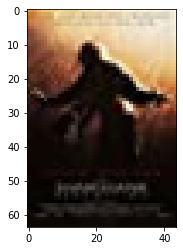

In [138]:
imdbDataset = IMDB()
imdbDataset.displayImage(0)

In [139]:
imdbDataset.df

,Movie Title,Year Published,IMDb Rating,Movie Poster
0,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",1994,9.2,"[[[231, 155, 79], [221, 148, 71], [223, 155, 8..."
1,"Francis Ford Coppola (dir.), Marlon Brando, Al...",1972,9.2,"[[[2, 1, 0], [6, 5, 3], [0, 0, 2], [0, 0, 2], ..."
2,"Francis Ford Coppola (dir.), Al Pacino, Robert...",1974,9.0,"[[[0, 2, 0], [0, 1, 0], [1, 0, 2], [1, 0, 4], ..."
3,"Christopher Nolan (dir.), Christian Bale, Heat...",2008,9.0,"[[[21, 48, 78], [66, 94, 117], [152, 179, 195]..."
4,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",1957,9.0,"[[[241, 245, 228], [252, 253, 247], [255, 253,..."
...,...,...,...,...
245,"Peter Bogdanovich (dir.), Timothy Bottoms, Jef...",1971,8.0,"[[[226, 226, 226], [226, 226, 226], [233, 233,..."
246,"Edward Zwick (dir.), Leonardo DiCaprio, Djimon...",2006,8.0,"[[[15, 0, 0], [34, 14, 16], [31, 6, 17], [20, ..."
247,"Danny Boyle (dir.), Dev Patel, Freida Pinto",2008,8.0,"[[[0, 0, 2], [0, 1, 2], [0, 3, 2], [0, 3, 2], ..."
248,"Richard Brooks (dir.), Elizabeth Taylor, Paul ...",1958,8.0,"[[[237, 255, 243], [243, 255, 231], [255, 253,..."


In [158]:
WANDB_ON = False

config = wandb.config
config.learning_rate = 0.001
config.batch_size = 8
config.epochs = 500
config.validation_split = .2
config.shuffle_dataset = True
config.random_seed= 42

In [159]:
# Creating data indices for training and validation splits:
dataset_size = len(imdbDataset)
indices = list(range(dataset_size))
split = int(np.floor(config.validation_split * dataset_size))
if config.shuffle_dataset :
    np.random.seed(config.random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
    imdbDataset, 
    batch_size=config.batch_size, 
    sampler=train_sampler
)

test_loader = torch.utils.data.DataLoader(
    imdbDataset, 
    batch_size=config.batch_size,
    sampler=test_sampler
)

In [160]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
              
        return x

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [161]:
#Instantiate the model
model = ConvAutoencoder()

#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = optim.Adam(model.parameters())

In [162]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [163]:
device = get_device()
print(f'Device: {device}')
model.to(device)
print(f'Number of weights: {model.count_parameters()}')

Device: cuda:0
Number of weights: 1495


In [164]:
if WANDB_ON:
    run = wandb.init(project='MovieWeb', entity='cmerrill')
    wandb.watch(model)

In [165]:
for epoch in range(1, config.epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    # Training
    for images in train_loader:
        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader)
    
    if WANDB_ON:
        wandb.log({"loss": train_loss})

    #monitor testing loss
    test_loss = 0.0

    # Testing
    for images in test_loader:
        images = images.cuda()
        outputs = model(images)
        loss = criterion(outputs, images)
        test_loss += loss.item()*images.size(0)
    
    test_loss = test_loss/len(test_loader)
    
    if WANDB_ON:
        wandb.log({"test_loss": test_loss})

    print('Epoch {} | Train Loss: {:.4f} |  Test Loss: {:.4f}'.format(epoch, train_loss, test_loss))

ss: 0.1594 |  Test Loss: 0.1415
Epoch 117 | Train Loss: 0.1593 |  Test Loss: 0.1409
Epoch 118 | Train Loss: 0.1592 |  Test Loss: 0.1410
Epoch 119 | Train Loss: 0.1589 |  Test Loss: 0.1406
Epoch 120 | Train Loss: 0.1588 |  Test Loss: 0.1410
Epoch 121 | Train Loss: 0.1589 |  Test Loss: 0.1408
Epoch 122 | Train Loss: 0.1589 |  Test Loss: 0.1418
Epoch 123 | Train Loss: 0.1589 |  Test Loss: 0.1410
Epoch 124 | Train Loss: 0.1586 |  Test Loss: 0.1403
Epoch 125 | Train Loss: 0.1593 |  Test Loss: 0.1412
Epoch 126 | Train Loss: 0.1589 |  Test Loss: 0.1402
Epoch 127 | Train Loss: 0.1580 |  Test Loss: 0.1409
Epoch 128 | Train Loss: 0.1581 |  Test Loss: 0.1398
Epoch 129 | Train Loss: 0.1578 |  Test Loss: 0.1399
Epoch 130 | Train Loss: 0.1577 |  Test Loss: 0.1397
Epoch 131 | Train Loss: 0.1576 |  Test Loss: 0.1409
Epoch 132 | Train Loss: 0.1574 |  Test Loss: 0.1394
Epoch 133 | Train Loss: 0.1573 |  Test Loss: 0.1398
Epoch 134 | Train Loss: 0.1572 |  Test Loss: 0.1403
Epoch 135 | Train Loss: 0.1571 |

In [166]:
if WANDB_ON:
    run.finish()

Test Images


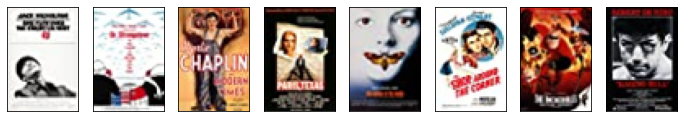

Reconstructed Images


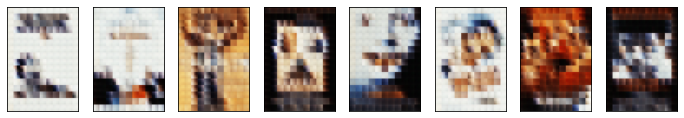

In [167]:
#Batch of test images
dataiter = iter(test_loader)
images = dataiter.next()
images = images.cuda()

#Sample outputs
outputs = model(images)
images = images.cpu().data.numpy()
outputs = outputs.cpu().data.numpy()

#Original Images
print("Test Images")
f, axarr = plt.subplots(1,config.batch_size,figsize=(12,12))
for idx in np.arange(config.batch_size):
    axarr[idx].imshow(np.moveaxis(images[idx], 0, -1))
    axarr[idx].tick_params(
        left=False, 
        right=False , 
        labelleft=False ,
        labelbottom=False, 
        bottom=False
    )
plt.show()

#Reconstructed Images
print('Reconstructed Images')
f, axarr = plt.subplots(1,config.batch_size,figsize=(12,12))
for idx in np.arange(config.batch_size):
    axarr[idx].imshow(np.moveaxis(outputs[idx], 0, -1))
    axarr[idx].tick_params(
        left=False, 
        right=False , 
        labelleft=False ,
        labelbottom=False, 
        bottom=False
    )
plt.show()